Import Libraries

In [109]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

Download Dataset

In [19]:
!git clone https://github.com/saraalemadi/DroneAudioDataset.git

fatal: destination path 'DroneAudioDataset' already exists and is not an empty directory.


Extract Audio Features (MFCC)

In [5]:
# upload Audio File
audio, sr = librosa.load('/content/DroneAudioDataset/Binary_Drone_Audio/yes_drone/B_S2_D1_067-bebop_000_.wav', duration=5.0)

# Get MFCC
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

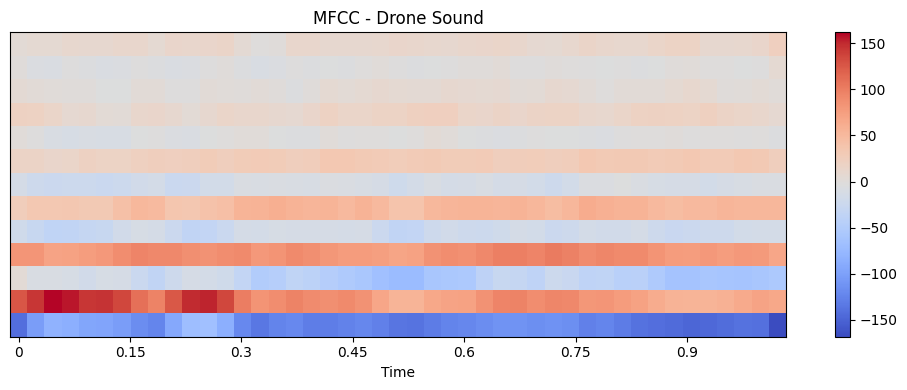

In [5]:
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC - Drone Sound')
plt.tight_layout()
plt.show()

Extract features for each audio file

In [110]:
drone_path = "/content/DroneAudioDataset/Binary_Drone_Audio/yes_drone"
non_drone_path = "/content/DroneAudioDataset/Binary_Drone_Audio/unknown"

def extract_mfcc(file_path, max_len=100, n_mfcc=13):

    audio, sr = librosa.load(file_path, sr=None)

    # Extract MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # Uniformity of length
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]

    return mfccs.T

In [112]:
# Upload Data
def load_data(path, label, max_len=100):
    features = []
    labels = []
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        mfcc = extract_mfcc(file_path, max_len)
        features.append(mfcc)
        labels.append(label)
    return np.array(features), np.array(labels)

In [113]:
X_drone, y_drone = load_data(drone_path, 1)
X_non, y_non = load_data(non_drone_path, 0)

# Data Merging
X = np.concatenate((X_drone, X_non), axis=0)
y = np.concatenate((y_drone, y_non), axis=0)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=24
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1266
  warnings.warn(


In [114]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print(X_train.shape)

(9363, 100, 13)


Build Model

In [103]:
# Build Model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', padding='same' ,input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.3),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [104]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)              │ (None, 100, 32)        │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 48, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 22, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,569 (834.25 KB)

 Trainable params: 213,121 (832.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [105]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9339 - loss: 0.1860 - val_accuracy: 0.9821 - val_loss: 0.0523
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9825 - loss: 0.0604 - val_accuracy: 0.9970 - val_loss: 0.0102
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9910 - loss: 0.0294 - val_accuracy: 0.9970 - val_loss: 0.0087
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9924 - loss: 0.0202 - val_accuracy: 0.9983 - val_loss: 0.0054
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9958 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 6.0123e-04
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.0104 - val_accuracy: 0.9996 - val_loss: 8.0576e-04
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9948 - loss: 0.0169 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9985 - loss: 0.0067 - val_ac

In [106]:
#evaluation the model
loss , accuracy = model.evaluate(X_test,y_test)
print('accuracy:', accuracy * 100, '%')

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0057
accuracy: 99.7009813785553 %


Drawing training results

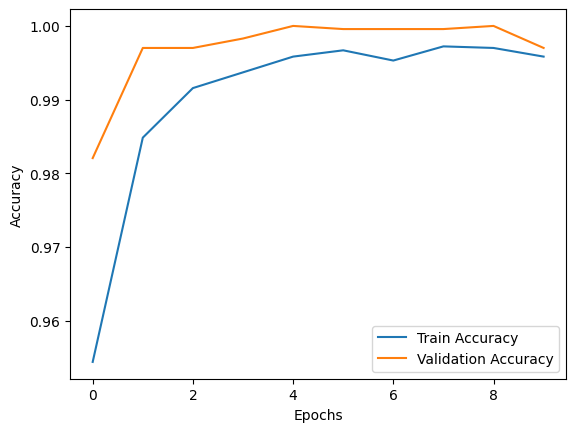

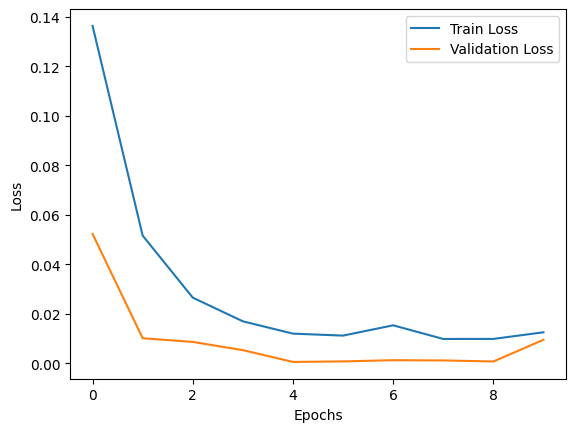

In [116]:
# Drawing training results

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [117]:
# Save model
model.save('drone_audio_detection_model.h5')